# Semantic Segmentation for Self Driving Cars

The goal of this model is to be able to classify each pixel of each object seen in an image or video feed on a self driving vehicle. It is useful in helping card identify objects around them which allows them to be 'aware' of their sorroundings.

It was trained on the Mapillary Research Dataset, which contains 18000 training images, 5000 validation images, and X testing images. This dataset contains a variety of images of road driving conditions from around the world, which can be used to train neural networks for computer vision in self driving cars.

The dataset also contains labels (masks) for each image which have each of their pixels labelled individually as a unique class, based on the type of object they are a part of in the image. We will be using this data to train our neural network.

To obtain the dataset, you can download it from the Mapillary Dataset website after registering. 

It can be found at https://www.mapillary.com/dataset/ 

**Note:** All the function definitions used in this notebook can be found in the semantic_segmentation.py file

#### Neural Network



The Neural Network architecture we use for our purposes uses a U-net architecture. This was originally designed to isolate various body tissues in medical imaging. It gets its name from the shape of its architecture which is shown below.


The Unet contains a series of convolutions and pooling layers, with a few 'skip connections that connect directly from the encoding stages to the corresponding decoding stages.

Lets start with importing all the necessary libraries.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Training this model can take a long time (many hours) so make sure you are using the GPU version of tensorflow to speed it up as much as possible. Let's verify that we have a GPU available.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Hyperparameters

We set the hyperparameters for the model here.

In [3]:
img_width = 256
img_height = 256
batch_size = 5
num_epochs = 20
seed = 42

## Image Preprocessing

The Mapillary Dataset provides very high resolution images (4K) that can be used for professional and research applications, but can also be computationally expensive. For our purposes we resize the images to a 256 x 256 resolution to reduce the computational cost. (It still takes a really long time to train).

You can use the Image Preprocessing notebook to independently preprocess the images or run the following cell to do it here and return the path to the dataset. To have more control over the number of images in the training, validation and testing sets, use the notebook version.

In [4]:
# from image_preprocessor import resize_images
# DATA_DIRECTORY = resize_images(MAPILLARY_DATASET, img_size = (256, 256), num_images = 'all')

We set the locations of the image directories. MAPILLARY_DATASET is the path to the original folder. DATA_DIRECTORY should the the folder you have inside after processing the images using the Image Processor notebook or function.

In [5]:
MAPILLARY_DATASET = '/home/anupjsebastian/mapillary_dataset/'
DATA_DIRECTORY = '/home/anupjsebastian/mapillary_dataset/resized_256'

Let's import a function to read the images into tensorflow and then preview them.

In [6]:
from semantic_segmentation import read_images

In [7]:
train_image_tensors, train_label_tensors , num_train_images= read_images(DATA_DIRECTORY, 'training', masks = True)
val_image_tensors, val_label_tensors, num_val_images = read_images(DATA_DIRECTORY, 'validation', masks = True)
test_image_tensors, num_test_images = read_images(DATA_DIRECTORY, 'testing', masks = False)

5000 image files found in training/images folder.
5000 mask files found in training/labels folder.
300 image files found in validation/images folder.
300 mask files found in validation/labels folder.
500 image files found in testing/images folder.


## Visualization

Let's now preview some of the images and their corresponding labels.

In [8]:
from semantic_segmentation import show_images_and_labels

Starting with the training set

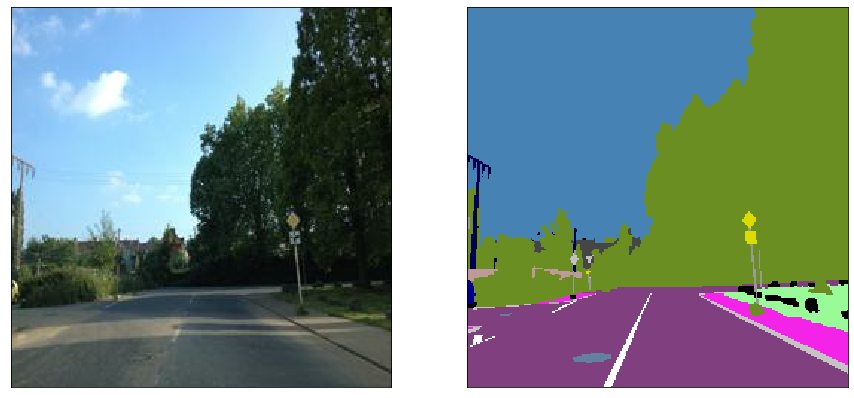

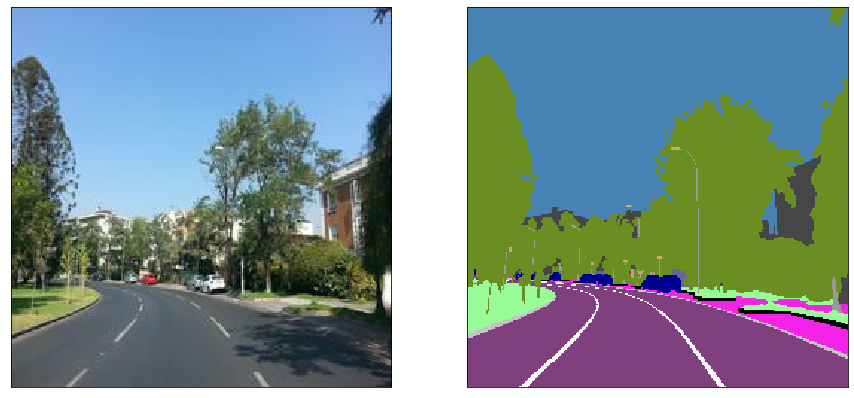

In [9]:
## Training Images
show_images_and_labels(train_image_tensors, train_label_tensors, num_images_to_show= 2)

Then the validation set

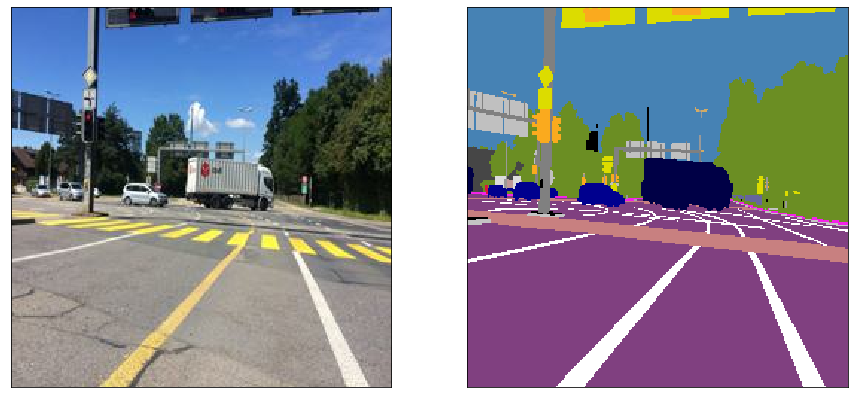

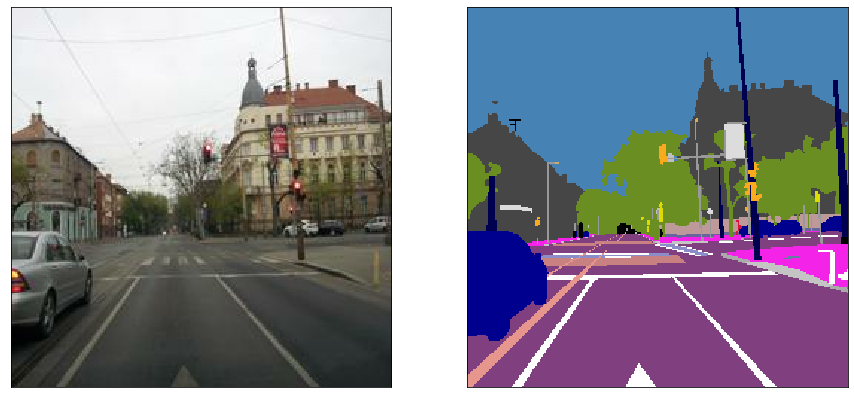

In [10]:
## Validation Images
show_images_and_labels(val_image_tensors, val_label_tensors, num_images_to_show= 2)

And finally the test set

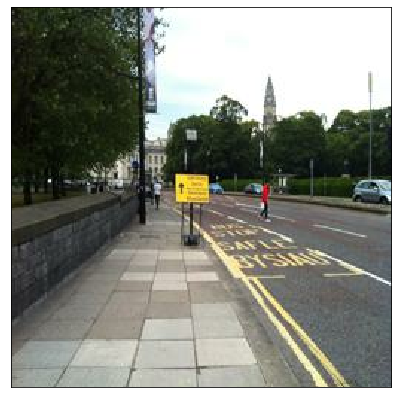

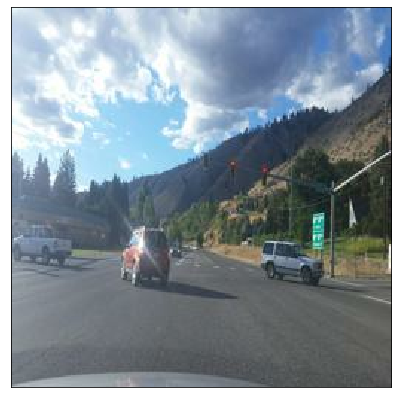

In [11]:
#Test Images
show_images_and_labels(test_image_tensors, num_images_to_show= 2, masks = False)

## Image Information

The creators of the dataset also provide a config file with information about the various classes in the labels. For our purposes we need to obtain the name of each of the classes and also the RGB color value for the corresponding labels. It should already be there in the same folder where the images are saved.

Let's now read this information from the file

In [12]:
config = os.path.join(MAPILLARY_DATASET, 'config.json')

# read in config file
with open(config) as config_file:
    config = json.load(config_file)
# in this example we are only interested in the labels
labels = config['labels']

In [13]:
num_categories = len(labels)

In [14]:
labels[0]

{'color': [165, 42, 42],
 'instances': True,
 'readable': 'Bird',
 'name': 'animal--bird',
 'evaluate': True}

In [15]:
num_classes = len(labels)
label_names = [label['readable'] for label in labels]
label_colors = [label['color'] for label in labels]

## Mapping Label and Color Codes. 

We will now create conversion dictionaries that can convert back and forth the label names, and label RGB values into numerical codes. We will one hot encode each category of the label into a different layer in the tensor, so this will be useful for that

In [16]:
id_to_name = {ID:name for ID, name in enumerate(label_names)}
name_to_id = {name:ID for ID, name in enumerate(label_names)}

In [17]:
id_to_color = {ID:tuple(color) for ID, color in enumerate(label_colors)}
color_to_id = {tuple(color):ID for ID, color in enumerate(label_colors)}

Now let's define functions to one hot encode the RGB image, and to convert it back as well.

## Input Pipeline

Since we have a lot of data, lets create an input pipeline that can efficiently load and process the images for training.

In [18]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

Let's import a defined Data Generator to efficiently load batches of images into the network for training

In [19]:
from semantic_segmentation import DataGenerator

## Model Definition

Finally let's import the network architecture oand then create an instance of it. 


To change the architecture you can modify the *semantic_segmentation.py* file. You could modify (increase) the number of downblocks, upblocks and bottleneck stages if you decide to use larger images.

In [20]:
from semantic_segmentation import unet

In [21]:
model = unet(n_filters = num_categories)

Input Shape: Tensor("input_1:0", shape=(None, 256, 256, 3), dtype=float32)


Now let's import some useful metrics that can be helpful to train our model.

In [22]:
from semantic_segmentation import dice_coef

Let's compile the model and get a summary of its architecture.

In [23]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[dice_coef,'accuracy'])


In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 66) 1848        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 66) 264         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 66) 39270       batch_normalization[0][0]        
______________________________________________________________________________________________

## Pretrained Weights

As the model takes a long time to train, you could load pretrained weights for the model by running the following cell. The model was trained to 91% training and 85% validation accuracy on the complete Mapillary dataset. You could also optionally run the next cell to run a cycle of validation on the current dataset you are using and obtain some useful metrics.

In [25]:
# model.load_weights("mapillary_full_dataset_weights.h5")


In [26]:
# model.evaluate(DataGenerator(DATA_DIRECTORY, 'validation', val_frames_datagen, val_masks_datagen))

## Callbacks

Let's setup some callbacks to run while the model trains. We use Tensorboard to log all the training information, use ModelCheckpoint to create checkpoints as we train our model so we do not lose progress if the model gets interrupted for any reason, and finally EarlyStopping to stop our model early if it starts to overfit or if it stop improving.

In [27]:
tensorboard = TensorBoard(log_dir='logs', write_graph=True)
checkpoints = ModelCheckpoint(mode='max', filepath='checkpoints/mapillary_model_checkpoint.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
earlystop = EarlyStopping(mode='max', monitor='val_accuracy', patience=3, verbose=1)
callbacks = [tensorboard, checkpoints, earlystop]

Let's do a quick calculation for the number of training and validation steps required. This is optional and the model can calculate automatically if not provided, but it can be changed for finer control.

In [28]:
train_steps = num_train_images//batch_size
val_steps = num_val_images//batch_size

## Tensorboard

We can monitor our progress using Tensorboard within the notebook by running the following cell.

In [29]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4482), started 0:34:24 ago. (Use '!kill 4482' to kill it.)

## Training 

Finally let's train our model, and save its final weights.

In [30]:
# Train model
result = model.fit(DataGenerator(DATA_DIRECTORY, 'training', train_frames_datagen, train_masks_datagen, id_to_color), steps_per_epoch = train_steps,
                validation_data = DataGenerator(DATA_DIRECTORY, 'validation', val_frames_datagen, val_masks_datagen, id_to_color), 
                validation_steps = val_steps, epochs = num_epochs, callbacks = callbacks)


In [31]:
model.save_weights("mapillary_model_final_weights.h5", overwrite=True)

## Predictions

Finally lets use our model to make a few predictions, from the test set and the training set, and visualize the results

In [32]:
train_generator = DataGenerator(DATA_DIRECTORY, 'training', train_frames_datagen, train_masks_datagen, id_to_color)
test_generator = DataGenerator(DATA_DIRECTORY, 'validation', val_frames_datagen, val_masks_datagen, id_to_color)

Let's import a function to quickly make predictions, process our output and plot the results.

In [33]:
from semantic_segmentation import display_predictions

#### Training Set

Note: you can rerun the cell below multiple times to show the next batch of images.

Found 5000 images belonging to 1 classes.
Found 5000 images belonging to 1 classes.


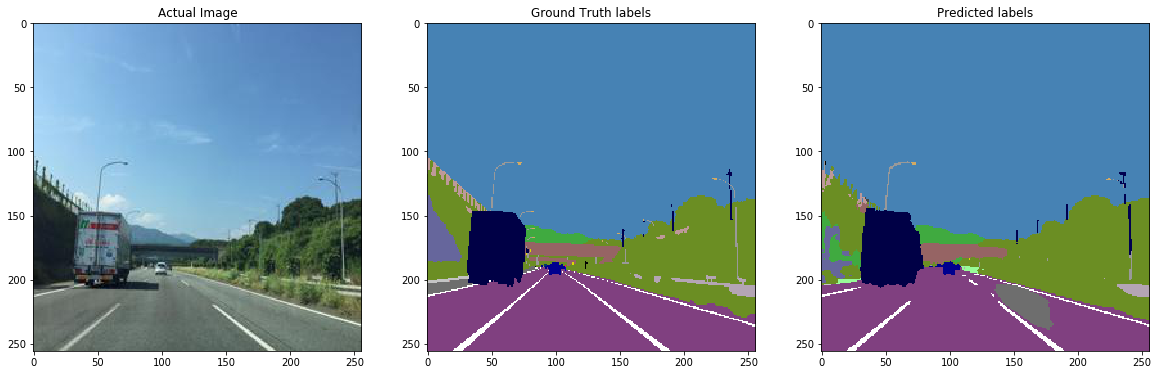

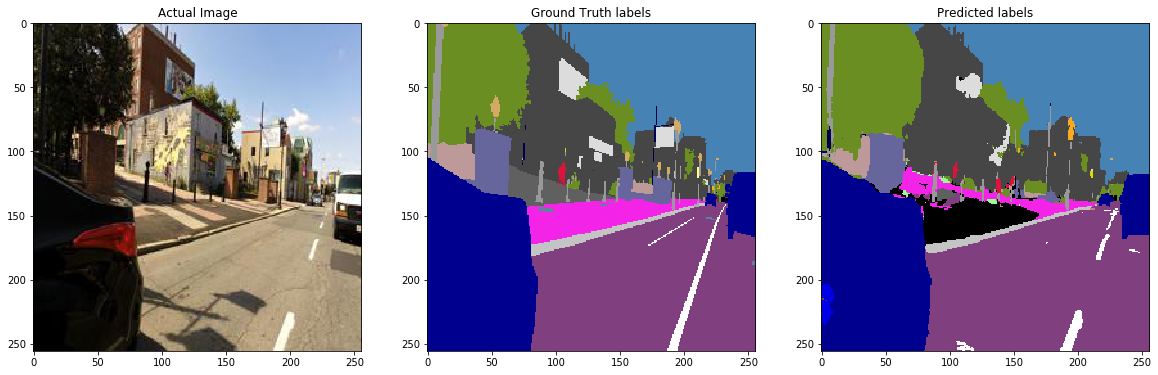

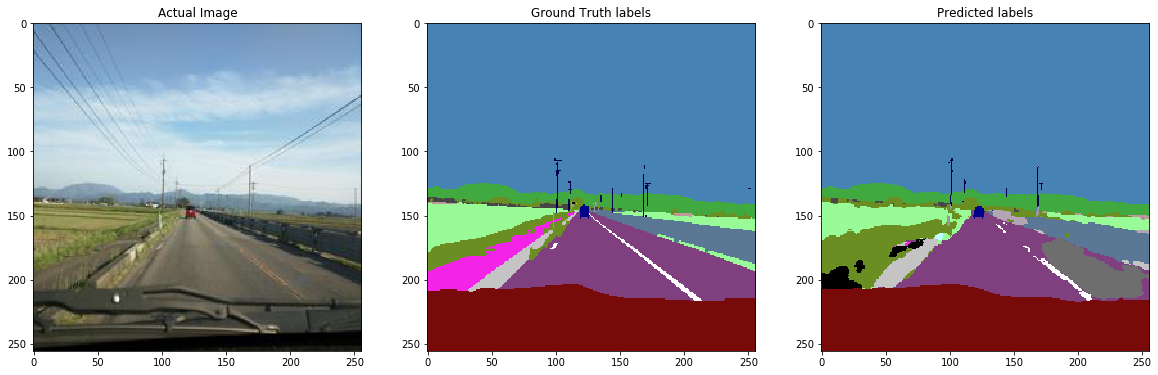

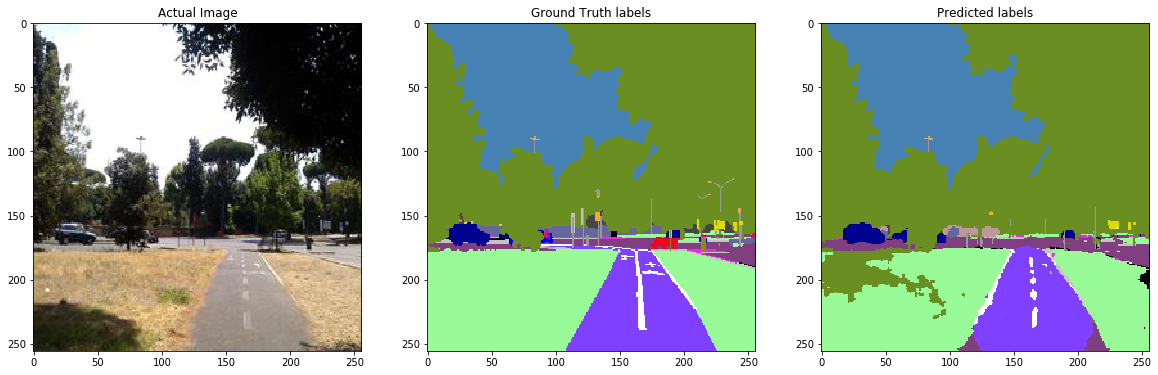

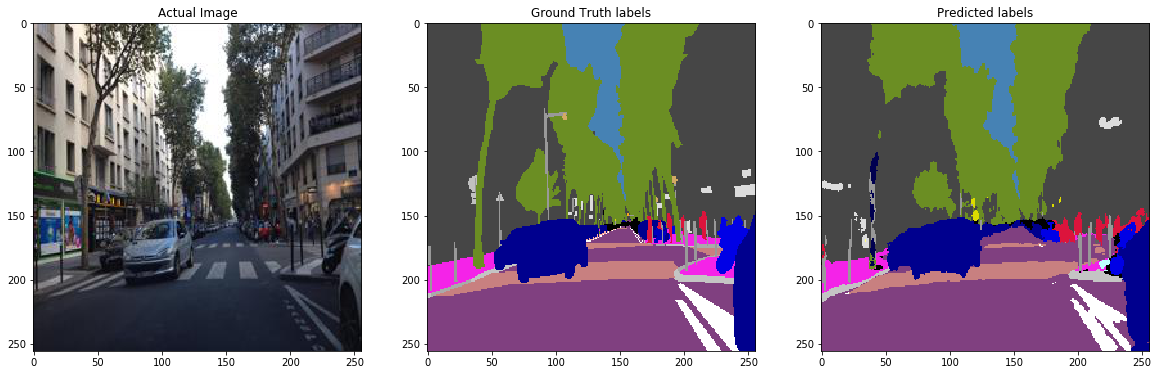

In [34]:
display_predictions(train_generator, id_to_color, model)

#### Validation Set

Found 300 images belonging to 1 classes.
Found 300 images belonging to 1 classes.


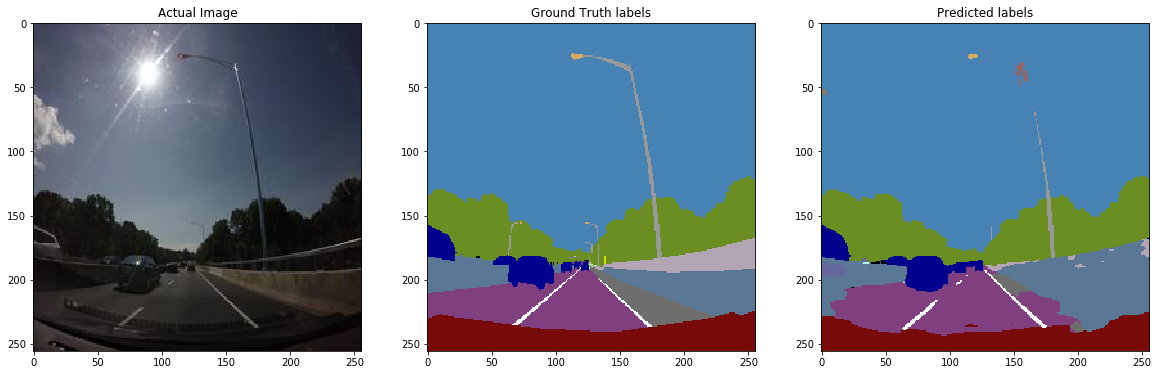

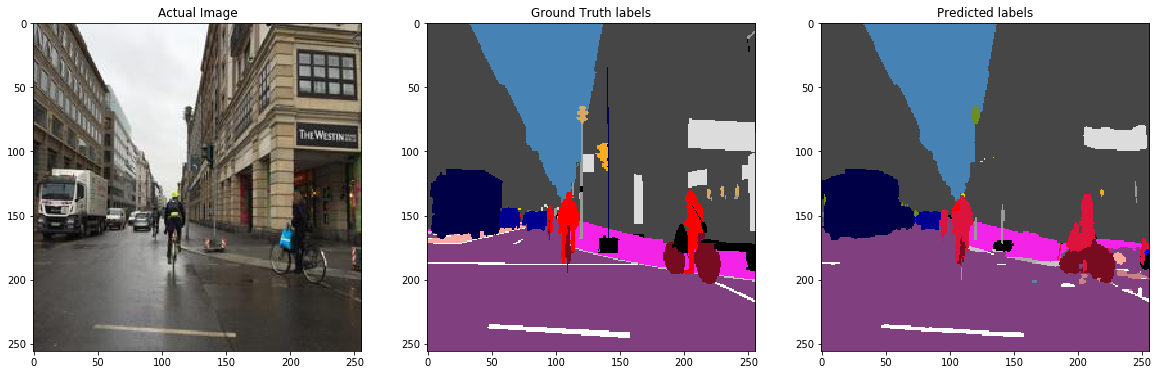

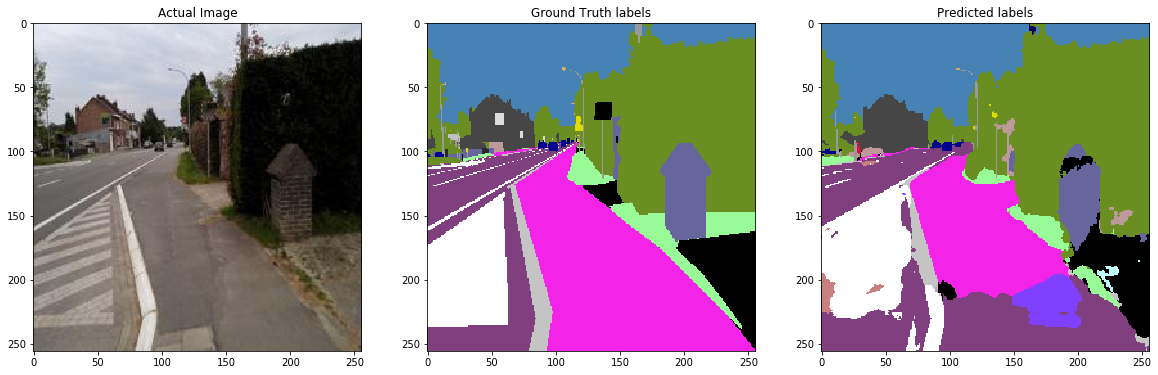

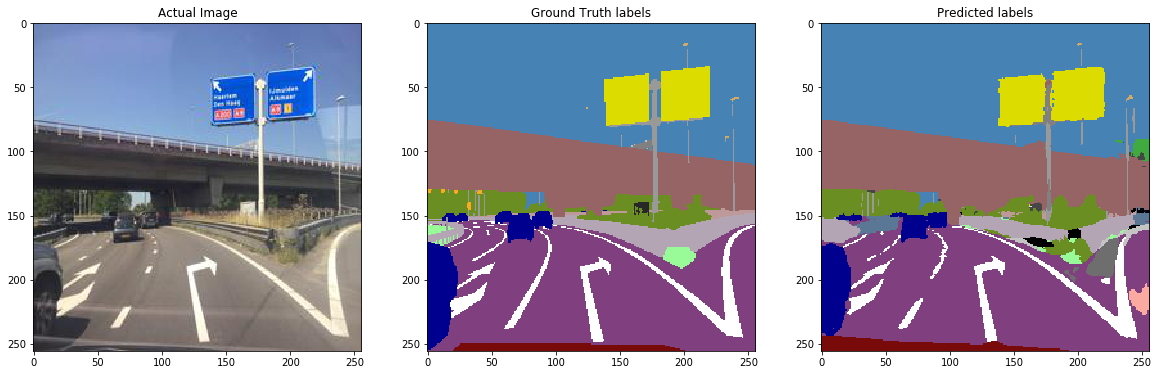

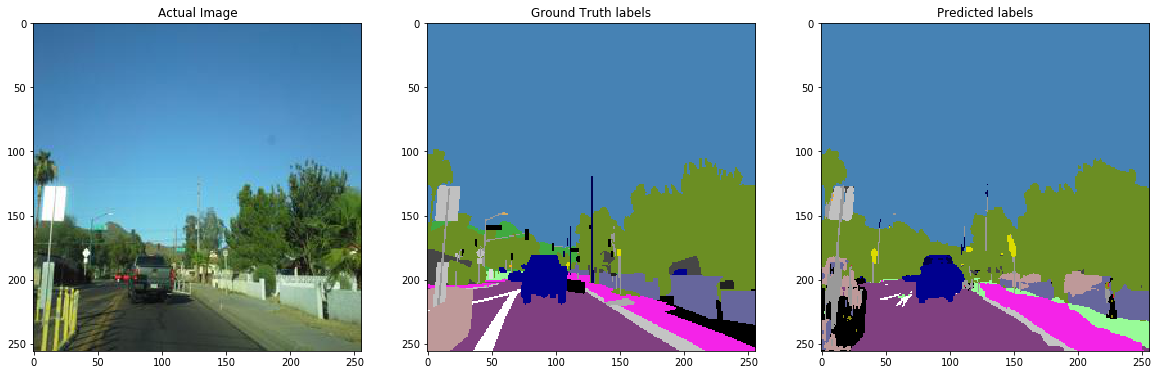

In [36]:
display_predictions(test_generator, id_to_color, model)